In [2]:
import pandas as pd

df = pd.read_csv("화재발생_현황_20251207.csv", header=None)

# 상위 3줄이 header 역할 → MultiIndex header 생성
new_header = df.iloc[0:3].T  # 전치해서 컬럼 구조로
df_clean2 = df.iloc[3:].reset_index(drop=True)  # 실제 데이터 부분

# 컬럼 이름 합치기
df_clean2.columns = new_header.apply(lambda x: "_".join(x.astype(str)), axis=1)

df_clean2.head()

,동별(1)_동별(1)_동별(1),동별(2)_동별(2)_동별(2),2024_발생 (건)_소계,2024_발생 (건)_실화,2024_발생 (건)_방화,2024_발생 (건)_기타,2024_소실_동수 (동),2024_소실_이재세대수 (가구),2024_소실_면적 (m²),2024_피해액 (천원)_소계,...,2024_사망 (명)_소계,2024_사망 (명)_남,2024_사망 (명)_여,2024_사망 (명)_미상,2024_부상 (명)_소계,2024_부상 (명)_남,2024_부상 (명)_여,2024_부상 (명)_미상,2024_이재민수 (명)_소계,2024_인명구조 (명)_소계
0,합계,소계,5654,5048,89,517,348,340,34822,21583897,...,23,14,9,-,305,171,121,13,740,426
1,합계,종로구,197,174,4,19,26,6,2039,656484,...,4,2,2,-,12,2,4,6,19,15
2,합계,중구,173,162,3,8,31,36,859,945605,...,-,-,-,-,6,4,2,-,85,9
3,합계,용산구,146,124,4,18,3,8,368,296677,...,1,1,-,-,6,4,2,-,15,8
4,합계,성동구,174,127,2,45,3,3,549,454383,...,1,1,-,-,9,6,3,-,3,6


In [3]:
!pip install pandas numpy matplotlib seaborn folium geopandas requests

   ---------------------------------------- 0.0/22.9 MB ? eta -:--:--
   ---------------------------------------- 0.3/22.9 MB ? eta -:--:--
   -- ------------------------------------- 1.3/22.9 MB 3.9 MB/s eta 0:00:06
   ---- ----------------------------------- 2.6/22.9 MB 4.9 MB/s eta 0:00:05
   ------ --------------------------------- 3.9/22.9 MB 5.2 MB/s eta 0:00:04
   --------- ------------------------------ 5.2/22.9 MB 5.4 MB/s eta 0:00:04
   ---------- ----------------------------- 6.3/22.9 MB 5.5 MB/s eta 0:00:04
   ------------- -------------------------- 7.6/22.9 MB 5.5 MB/s eta 0:00:03
   --------------- ------------------------ 8.9/22.9 MB 5.6 MB/s eta 0:00:03
   ----------------- ---------------------- 10.2/22.9 MB 5.7 MB/s eta 0:00:03
   ------------------- -------------------- 11.0/22.9 MB 5.5 MB/s eta 0:00:03
   -------------------- ------------------- 11.5/22.9 MB 5.2 MB/s eta 0:00:03
   --------------------- ------------------ 12.6/22.9 MB 5.2 MB/s eta 0:00:03
   ------


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
import pandas as pd
import numpy as np

# 파일명은 상황에 맞게 변경
merged = pd.read_csv("merged.csv", encoding="utf-8-sig")       # 이전에 만든 merged 파일
df_clean = pd.read_csv("화재발생_현황_20251207.csv", encoding="utf-8-sig")   # 소실면적 등 들어있는 원본 화재데이터

# 컬럼명 통일: merged의 구 컬럼명이 '구'라고 가정, df_clean은 두번째 컬럼이 구명이라 가정
merged = merged.rename(columns={merged.columns[0]: merged.columns[0]})  # 필요시 수정
merged = merged.rename(columns={ '구': 'district' } ) if '구' in merged.columns else merged
df_clean = df_clean.rename(columns={df_clean.columns[1]: 'district'})

# 숫자형 안전 처리(문자형 숫자 방지)
for col in ["화재건수", "30년이상_건물수", "전체건물수"]:
    if col in merged.columns:
        merged[col] = pd.to_numeric(merged[col], errors="coerce")


In [6]:
# (1) 서울시 자치구별 면적 (km²) — 사용자 제공
seoul_area = {
    "종로구": 23.91, "중구": 9.96, "용산구": 21.87, "성동구": 16.86, "광진구": 17.06,
    "동대문구": 14.22, "중랑구": 18.50, "성북구": 24.58, "강북구": 23.60, "도봉구": 20.65,
    "노원구": 35.44, "은평구": 29.71, "서대문구": 17.63, "마포구": 23.85, "양천구": 17.41,
    "강서구": 41.44, "구로구": 20.12, "금천구": 13.02, "영등포구": 24.55, "동작구": 16.35,
    "관악구": 29.57, "서초구": 46.98, "강남구": 39.50, "송파구": 33.87, "강동구": 24.59
}

# df_clean에 area_km2, area_m2 추가
df_clean['area_km2'] = df_clean['district'].map(seoul_area)
df_clean['area_m2'] = df_clean['area_km2'] * 1_000_000  # km^2 -> m^2

In [14]:
# 소실면적 컬럼 자동 탐색
damage_cols = [col for col in df_clean2.columns if "소실" in col and ("면적" in col or "m²" in col or "m2" in col)]

if not damage_cols:
    raise RuntimeError("❌ '소실면적' 관련 컬럼을 찾을 수 없음. df_clean 컬럼명 확인 필요.")
    
damage_col = damage_cols[0]
print(f"📌 자동 탐색된 소실면적 컬럼: {damage_col}")

# 숫자형 변환
df_clean2[damage_col] = pd.to_numeric(df_clean2[damage_col], errors="coerce")

# 구별 총 소실면적 계산
damage_by_district = (
    df_clean2.groupby("동별(2)_동별(2)_동별(2)", as_index=False)[damage_col]
    .sum()
    .rename(columns={damage_col: "total_damage_area_m2"})
)

damage_by_district


📌 자동 탐색된 소실면적 컬럼: 2024_소실_면적 (m²)


,동별(2)_동별(2)_동별(2),total_damage_area_m2
0,강남구,1557
1,강동구,797
2,강북구,814
3,강서구,829
4,관악구,361
5,광진구,793
6,구로구,872
7,금천구,1178
8,노원구,907
9,도봉구,227


In [22]:
merged_df=pd.read_csv('merged.csv')

damage_by_district.rename(columns={damage_by_district.columns[0]: "구"}, inplace=True)
merged2 = merged_df.merge(damage_by_district, how="left", left_on="구", right_on="구")

In [23]:
merged2

,구,화재건수,30년이상_건물수,전체건물수,total_damage_area_m2
0,강남구,2024,63192,4468163192,1557
1,송파구,1691,57744,5207457744,696
2,영등포구,1366,36301,3545436301,3484
3,마포구,1334,27730,4138527730,724
4,관악구,1304,36564,4773436564,361
5,강서구,1246,50079,6749050079,829
6,서초구,1179,30261,3284830261,845
7,서대문구,1092,27285,3431327285,262
8,성북구,1031,28653,4565028653,864
9,은평구,1008,34091,3744634091,651


In [25]:
# (1) 서울시 자치구별 면적 (km²)
seoul_area = {
    "종로구": 23.91, "중구": 9.96, "용산구": 21.87, "성동구": 16.86, "광진구": 17.06,
    "동대문구": 14.22, "중랑구": 18.50, "성북구": 24.58, "강북구": 23.60, "도봉구": 20.65,
    "노원구": 35.44, "은평구": 29.71, "서대문구": 17.63, "마포구": 23.85, "양천구": 17.41,
    "강서구": 41.44, "구로구": 20.12, "금천구": 13.02, "영등포구": 24.55, "동작구": 16.35,
    "관악구": 29.57, "서초구": 46.98, "강남구": 39.50, "송파구": 33.87, "강동구": 24.59
}

# (2) km² → m²로 변환 후 매핑
merged2["area_m2"] = merged2["구"].map(seoul_area) * 1_000_000

In [ ]:
merged2["damage_ratio"] = merged2["total_damage_area_m2"] / merged2["area_m2"]

In [ ]:
# merged의 구 컬럼명 통일: 'district'로 맞춤
if '구' in merged.columns:
    merged = merged.rename(columns={'구':'district'})

# old_ratio 계산: 30년 이상 건물수 / 면적 (컬럼명은 merged 파일에 맞춰 조정)
if "30년이상_건물수" in merged2.columns and "area_m2" in merged2.columns:
    merged2["30년이상_건물수"] = pd.to_numeric(merged2["30년이상_건물수"], errors="coerce")
    merged2["area_m2"] = pd.to_numeric(merged2["area_m2"], errors="coerce")
    merged2["old_ratio"] = (merged2["30년이상_건물수"] / merged2["area_m2"]) * 100
else:
    # old_ratio가 이미 있으면 사용; 없으면 경고
    if "old_ratio" not in merged2.columns:
        raise RuntimeError("merged에 '30년이상_건물수' 또는 '전체건물수'가 없습니다. old_ratio를 계산할 수 없음.")


In [41]:
merged2

,구,화재건수,30년이상_건물수,전체건물수,total_damage_area_m2,area_m2,damage_ratio,old_ratio,log_old_ratio,log_damage_ratio
0,강남구,2024,63192,4468163192,1557,39500000.0,3.484653e-07,0.001414,-1.832708,-10.141270
1,송파구,1691,57744,5207457744,696,33870000.0,1.336545e-07,0.001109,-1.769095,-10.792642
2,영등포구,1366,36301,3545436301,3484,24550000.0,9.826717e-07,0.001024,-1.911452,-8.860279
3,마포구,1334,27730,4138527730,724,23850000.0,1.749414e-07,0.000670,-2.151854,-10.402470
4,관악구,1304,36564,4773436564,361,29570000.0,7.562686e-08,0.000766,-2.090281,-11.313311
5,강서구,1246,50079,6749050079,829,41440000.0,1.228321e-07,0.000742,-2.113230,-10.819487
6,서초구,1179,30261,3284830261,845,46980000.0,2.572431e-07,0.000921,-2.742447,-10.925840
7,서대문구,1092,27285,3431327285,262,17630000.0,7.635529e-08,0.000795,-1.865850,-11.116701
8,성북구,1031,28653,4565028653,864,24580000.0,1.892650e-07,0.000628,-2.149260,-10.255842
9,은평구,1008,34091,3744634091,651,29710000.0,1.738488e-07,0.000910,-2.165035,-10.728439


In [42]:
# 상관계수 (raw)
corr_raw = merged2["old_ratio"].corr(merged2["damage_ratio"])
print(f"노후건물비율 vs 피해비율 (raw) 상관계수: {corr_raw:.4f}")

# 로그 변환 (0값 주의)
epsilon = 1e-9
merged2['log_old_ratio'] = np.log(merged2['old_ratio'] + epsilon)
merged2['log_damage_ratio'] = np.log(merged2['damage_ratio'] + epsilon)

corr_log = merged2['log_old_ratio'].corr(merged2['log_damage_ratio'])
print(f"노후건물비율 vs 피해비율 (log) 상관계수: {corr_log:.4f}")

노후건물비율 vs 피해비율 (raw) 상관계수: 0.8731
노후건물비율 vs 피해비율 (log) 상관계수: 0.6665


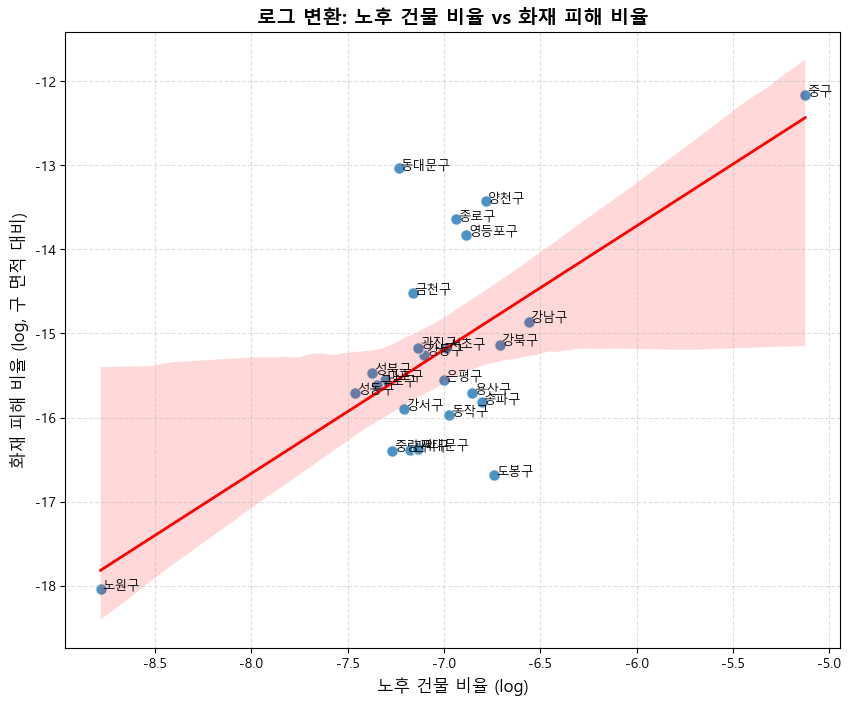

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
import platform
from matplotlib import rc

# -----------------------------------------------------------
# 1. 한글 폰트 설정 (그래프에서 한글 깨짐 방지)
# -----------------------------------------------------------
if platform.system() == 'Darwin':  # Mac
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':  # Windows
    rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False


# -----------------------------------------------------------
# 2. 그래프 그리기
# -----------------------------------------------------------
plt.figure(figsize=(10, 8)) # 이름이 들어가야 하니 크기를 조금 키웠습니다

# 산점도 + 회귀선
sns.regplot(
    x='log_old_ratio',
    y='log_damage_ratio',
    data=merged2,
    scatter_kws={'s':70, 'alpha':0.8, 'edgecolor':'white'}, # 테두리 추가해서 점 더 잘 보이게
    line_kws={'color':'red', 'linewidth':2}
)

# -----------------------------------------------------------
# 3. [핵심] 구 이름 텍스트 추가하기
# -----------------------------------------------------------
# '자치구' 부분은 실제 데이터프레임의 구 이름 컬럼명으로 수정해주세요! (예: '구', '구별')
target_gu_col = '구' 

for i in range(len(merged2)):
    row = merged2.iloc[i]
    
    # plt.text(x좌표, y좌표, 텍스트, 옵션)
    plt.text(
        row['log_old_ratio'] + 0.01,    # 점보다 살짝 오른쪽으로 이동 (겹침 방지)
        row['log_damage_ratio'],        # y좌표는 그대로
        row[target_gu_col],             # 표시할 구 이름
        fontsize=9,                     # 글자 크기
        color='black'                   # 글자 색상
    )

# -----------------------------------------------------------
# 4. 꾸미기
# -----------------------------------------------------------
plt.xlabel("노후 건물 비율 (log)", fontsize=12)
plt.ylabel("화재 피해 비율 (log, 구 면적 대비)", fontsize=12)
plt.title("로그 변환: 노후 건물 비율 vs 화재 피해 비율", fontsize=14, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.4)

plt.show()

In [48]:
# 1. csv 파일로 저장하기
# index=False: 불필요한 행 번호(0, 1, 2...) 저장을 막음
# encoding='utf-8-sig': 엑셀에서 한글 깨짐 방지 (필수!)
merged2.to_csv("merged2.csv", index=False, encoding="utf-8-sig")

# 2. 잘 저장됐는지 확인 (선택 사항)
import os
if os.path.exists("merged2.csv"):
    print("✅ 'merged2.csv' 파일이 성공적으로 저장되었습니다!")
else:
    print("❌ 파일 저장에 실패했습니다.")

✅ 'merged2.csv' 파일이 성공적으로 저장되었습니다!


In [53]:
# '자치구' 컬럼명은 실제 데이터에 맞게 확인해주세요 (예: '구', '지역' 등)
target_col = '구'

# 1. old_ratio 기준 오름차순 정렬 (작은 값 -> 큰 값)
sorted_df = merged2.sort_values(by='old_ratio', ascending=True)

# 2. 보기 좋게 '구 이름'과 '비율'만 뽑아서 출력
print("=== 노후 건물 비율 낮은 순(오름차순) ===")
print(sorted_df[[target_col, 'old_ratio']])

# 3. (참고) 상위 5개(가장 새 건물이 많은 곳) vs 하위 5개(가장 낡은 곳) 따로 보기
print("\n🆕 노후 비율이 가장 낮은 곳 Top 5")
print(sorted_df[[target_col, 'old_ratio']].head(5))

print("\n🏚️ 노후 비율이 가장 높은 곳 Top 5")
print(sorted_df[[target_col, 'old_ratio']].tail(5))

=== 노후 건물 비율 낮은 순(오름차순) ===
       구  old_ratio
18   노원구   0.000153
12   성동구   0.000573
8    성북구   0.000628
14   구로구   0.000644
3    마포구   0.000670
13   중랑구   0.000697
24  동대문구   0.000720
5    강서구   0.000742
4    관악구   0.000766
19   금천구   0.000775
7   서대문구   0.000795
15   광진구   0.000797
11   강동구   0.000823
9    은평구   0.000910
6    서초구   0.000921
21   동작구   0.000937
10   종로구   0.000970
2   영등포구   0.001024
16   용산구   0.001055
1    송파구   0.001109
23   양천구   0.001133
22   도봉구   0.001182
17   강북구   0.001217
0    강남구   0.001414
20    중구   0.005950

🆕 노후 비율이 가장 낮은 곳 Top 5
      구  old_ratio
18  노원구   0.000153
12  성동구   0.000573
8   성북구   0.000628
14  구로구   0.000644
3   마포구   0.000670

🏚️ 노후 비율이 가장 높은 곳 Top 5
      구  old_ratio
23  양천구   0.001133
22  도봉구   0.001182
17  강북구   0.001217
0   강남구   0.001414
20   중구   0.005950
